# README

- **Author**: `方珮潔`
- **Created At**: `2025-10-12`
- **Last Modified At**: `2025-10-13`

---

## What does this file do?

- `資料檢查與前處理`
  - `前置作業`
  - `結合兩張資料表`
  - `資料表形狀與前五列`
  - `資料型態與缺失值`
  - `數值欄位分佈`
  - `類別欄位分佈`
- `進階欄位生成`
  - `折扣率`
  - `遊戲年齡`
  - `累積評價正面率`
  - `是否為平台促銷期`
  - `玩家數、追蹤人數、正面率的指定期間增長率`
  - `欄位生成結果統整`
- `將列改為折扣事件導向`
- `結果檔案整理`
  - `刪除不需欄`
  - `欄位順序調整`
  - `結果檔案觀察`
- `輸出結果檔案`

---

## What does this file take?

- **Source Data Sets**:  
  1. `all_games_merged.csv` 
    - Description: `來自 merge-data-processing-code.ipynb 處理完的資料，欄位包含：` 
      - Players
      - Date
      - Final price
      - Followers
      - Positive reviews
      - Negative reviews
      - GameID
      - ReleaseDate
      - OriginPrice
      - Type
      - MultiPlayer
      - Publisher
      - ConstantDiscount
  2. `release_events_all_games.csv`
    - Description: `額外整理每個遊戲推出新 DLC 及續作的時間點，欄位包含：`
      - GameID
      - Date
      - Has_DLC
      - Has_Sequel
---

## What does this file output?

- `processed_data.csv`  
  - Description: `包含所有 DA 所需欄位的完整資料表，欄位包含：`
    - Date
    - GameID
    - Type
    - MultiPlayer
    - Publisher
    - ConstantDiscount
    - Age
    - DiscountRate
    - AccumulatedPositiveRate
    - SalePeriod
    - PlayerGrowthRate1W
    - PlayerGrowthRate2W
    - PlayerGrowthRate1M
    - FollowersGrowthRate1W
    - FollowersGrowthRate2W
    - FollowersGrowthRate1M
    - PositiveRateGrowthRate1W
    - PositiveRateGrowthRate2W
    - PositiveRateGrowthRate1M
    - DLC_since_last_discount
    - Sequel_since_last_discount



# 程式碼

## 資料檢查與前處理

### 前置作業

In [207]:
# 後續所需套件引入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [208]:
# 顯示所有欄與列
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 增加螢幕寬度
pd.set_option('display.width', 2000)

# 若欄位名稱太長也不截斷
pd.set_option('display.max_colwidth', None)

In [209]:
# 地端資料表讀取
all_games_df = pd.read_csv("/Users/peijiefang/Downloads/data analysis project/all_games_merged.csv") 
release_events_df = pd.read_csv("/Users/peijiefang/Downloads/data analysis project/release_events_all_games.csv")

### 結合兩張資料表

In [210]:
merged_df = pd.merge(all_games_df, release_events_df, on=['GameID', 'Date'], how='left')

# 把缺失值補成 0
merged_df['Has_DLC'] = merged_df['Has_DLC'].fillna(0)
merged_df['Has_Sequel'] = merged_df['Has_Sequel'].fillna(0)

df = merged_df.copy()

### 資料表形狀與前五列

In [211]:
# 資料表形狀
print("\n--- Shape ---")
print(df.shape)

# 資料表前五列
print("\n--- Head 5 rows ---")
print(df.head())


--- Shape ---
(29253, 15)

--- Head 5 rows ---
    Players        Date  Final price  Followers  Positive reviews  Negative reviews  GameID ReleaseDate  OriginPrice    Type  MultiPlayer              Publisher  ConstantDiscount  Has_DLC  Has_Sequel
0  122237.0  2023-01-01        120.0     927415            587533            -11350  431960  2018-11-16          120  Mature            0  Wallpaper Engine Team                 1      0.0         0.0
1  130721.0  2023-01-02        120.0     928018            588748            -11353  431960  2018-11-16          120  Mature            0  Wallpaper Engine Team                 1      0.0         0.0
2  129769.0  2023-01-03        120.0     928691            589351            -11368  431960  2018-11-16          120  Mature            0  Wallpaper Engine Team                 1      0.0         0.0
3  129385.0  2023-01-04        120.0     929333            589351            -11368  431960  2018-11-16          120  Mature            0  Wallpaper Eng

### 資料型態與缺失值

In [212]:
# 資料型態與缺失狀況
print("\n--- Data information ---")
print(df.info())


--- Data information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29253 entries, 0 to 29252
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Players           29071 non-null  float64
 1   Date              29253 non-null  object 
 2   Final price       29253 non-null  float64
 3   Followers         29253 non-null  int64  
 4   Positive reviews  29253 non-null  int64  
 5   Negative reviews  29253 non-null  int64  
 6   GameID            29253 non-null  int64  
 7   ReleaseDate       29253 non-null  object 
 8   OriginPrice       29253 non-null  int64  
 9   Type              29253 non-null  object 
 10  MultiPlayer       29253 non-null  int64  
 11  Publisher         29253 non-null  object 
 12  ConstantDiscount  29253 non-null  int64  
 13  Has_DLC           29253 non-null  float64
 14  Has_Sequel        29253 non-null  float64
dtypes: float64(4), int64(7), object(4)
memory usage: 3.3+ MB
None

In [213]:
# 特定欄位資料型態轉換
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'], errors='coerce')
df['GameID'] = df['GameID'].astype(str)

# 剩餘數值欄位轉為 float
cat_cols = df.select_dtypes(include=['object', 'category']).columns
exclude_cols = list(cat_cols) + ['Date', 'ReleaseDate']
num_cols = df.columns.difference(exclude_cols)
for col in num_cols:
    try:
        df[col] = df[col].astype(float)
    except Exception as e:
        print(f"欄位 {col} 轉換失敗: {e}")

# 驗證型態轉換結果
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29253 entries, 0 to 29252
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Players           29071 non-null  float64       
 1   Date              29253 non-null  datetime64[ns]
 2   Final price       29253 non-null  float64       
 3   Followers         29253 non-null  float64       
 4   Positive reviews  29253 non-null  float64       
 5   Negative reviews  29253 non-null  float64       
 6   GameID            29253 non-null  object        
 7   ReleaseDate       29253 non-null  datetime64[ns]
 8   OriginPrice       29253 non-null  float64       
 9   Type              29253 non-null  object        
 10  MultiPlayer       29253 non-null  float64       
 11  Publisher         29253 non-null  object        
 12  ConstantDiscount  29253 non-null  float64       
 13  Has_DLC           29253 non-null  float64       
 14  Has_Sequel        2925

In [214]:
# 設定成索引
df = df.set_index('Date')

# 缺失值補值
df['Players'] = df['Players'].interpolate(method='time')

# 後續還要用 Date 當欄位
df = df.reset_index()

In [215]:
# 再次檢查缺失狀況
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29253 entries, 0 to 29252
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              29253 non-null  datetime64[ns]
 1   Players           29253 non-null  float64       
 2   Final price       29253 non-null  float64       
 3   Followers         29253 non-null  float64       
 4   Positive reviews  29253 non-null  float64       
 5   Negative reviews  29253 non-null  float64       
 6   GameID            29253 non-null  object        
 7   ReleaseDate       29253 non-null  datetime64[ns]
 8   OriginPrice       29253 non-null  float64       
 9   Type              29253 non-null  object        
 10  MultiPlayer       29253 non-null  float64       
 11  Publisher         29253 non-null  object        
 12  ConstantDiscount  29253 non-null  float64       
 13  Has_DLC           29253 non-null  float64       
 14  Has_Sequel        2925

### 數值欄位分佈

In [216]:
print("\n--- Numerical Summary ---")
print(df[num_cols].describe())


--- Numerical Summary ---
       ConstantDiscount   Final price     Followers       Has_DLC    Has_Sequel   MultiPlayer  Negative reviews   OriginPrice        Players  Positive reviews
count      29253.000000  29253.000000  2.925300e+04  29253.000000  29253.000000  29253.000000      29253.000000  29253.000000   29253.000000      2.925300e+04
mean           0.200048    437.448809  5.097708e+05      0.000855      0.000137      0.466790     -18821.090726    442.853485   18864.076266      2.498793e+05
std            0.400043    364.467344  5.210622e+05      0.029222      0.011693      0.498904      33350.043540    366.519092   27067.643034      2.538792e+05
min            0.000000      0.000000  5.800000e+02      0.000000      0.000000      0.000000    -174531.000000     22.000000       1.000000      1.130000e+02
25%            0.000000    268.000000  1.960480e+05      0.000000      0.000000      0.000000     -15450.000000    268.000000    4243.000000      6.734100e+04
50%            0.00

### 類別欄位分佈


--- Categorical Summary ---

Value counts for GameID:
GameID
1172620    981
814380     978
477160     976
588650     976
381210     976
431730     975
244850     975
376210     975
548430     975
242760     975
413150     975
1145360    975
431960     975
880940     975
4000       975
108600     975
233860     975
294100     975
367520     975
1091500    975
644930     975
331790     974
10         974
457140     974
244210     974
323190     974
582660     974
3590       974
881100     974
423710     974
Name: count, dtype: int64


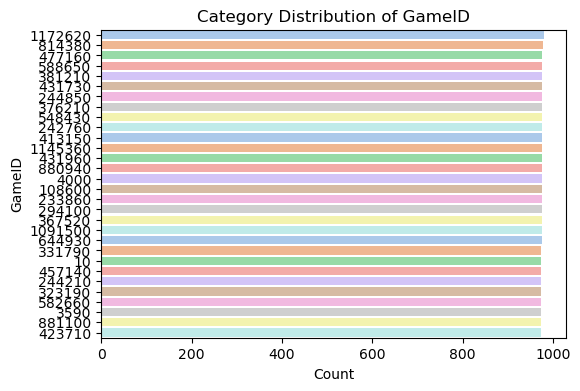


Value counts for Type:
Type
Sandbox                      2924
Open World                   1956
Survival                     1950
Colony Sim                   1949
RPG                          1948
Souls-like                    978
Horror                        976
Co-op                         976
Adventure                     976
Open World Survival Craft     975
Base Building                 975
Pixel Graphics                975
Dwarf                         975
Mature                        975
Farming Sim                   975
Funny                         975
Metroidvania                  975
Cyberpunk                     975
Action Roguelike              975
Action                        974
Racing                        974
City Builder                  974
Tower Defense                 974
Physics                       974
Name: count, dtype: int64


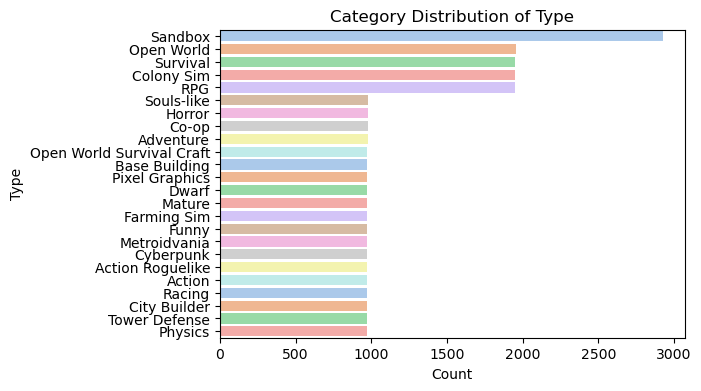


Value counts for Publisher:
Publisher
Valve                                                                             1949
New Reality Games                                                                 1948
Xbox Game Studios                                                                  981
Activision (Excluding Japan and Asia), FromSoftware, Inc. (Japan), 方块游戏 (Asia)     978
Behaviour Interactive Inc.                                                         976
Curve Games                                                                        976
Motion Twin                                                                        976
Wallpaper Engine Team                                                              975
Endnight Games Ltd                                                                 975
Afterthought LLC                                                                   975
Numantian Games                                                                    975
Igar

/Users/peijiefang/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22359 (\N{CJK UNIFIED IDEOGRAPH-5757}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28216 (\N{CJK UNIFIED IDEOGRAPH-6E38}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25103 (\N{CJK UNIFIED IDEOGRAPH-620F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


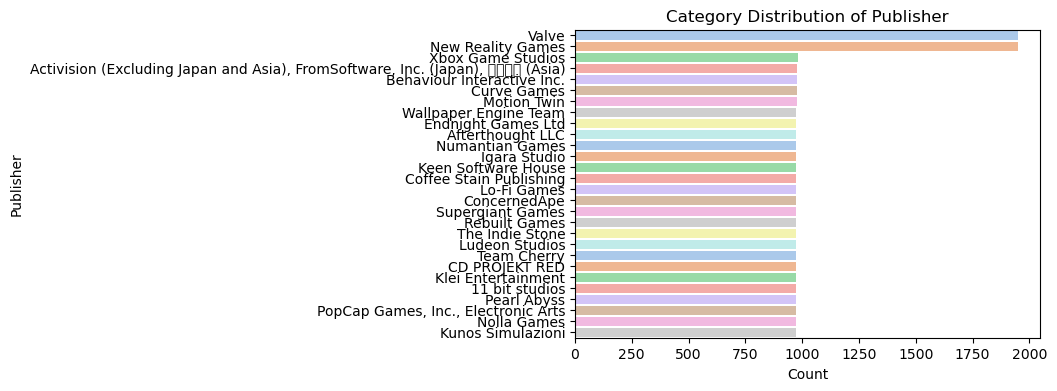

In [217]:
print("\n--- Categorical Summary ---")
for col in cat_cols[:]:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())

    plt.figure(figsize=(6, 4))
    sns.countplot(y=df[col], order=df[col].value_counts().index, palette="pastel")
    plt.title(f"Category Distribution of {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.show()

In [218]:
cleaned_df = df.copy()

## 進階欄位生成

### 折扣率

In [219]:
# 折扣率 = （原價 - 當下價格）/ 原價，因此為折扣率為正表示降價
cleaned_df['DiscountRate'] = (cleaned_df['OriginPrice'] - cleaned_df['Final price']) / cleaned_df['OriginPrice']

### 遊戲年齡

In [220]:
# 遊戲年齡（年） = 當下日期 - 推出日期
cleaned_df['Age'] = (cleaned_df['Date'] - cleaned_df['ReleaseDate']).dt.days / 365

### 累積評價正面率

In [221]:
cleaned_df['AccumulatedPositiveRate'] = cleaned_df['Positive reviews'] / (cleaned_df['Positive reviews'] - cleaned_df['Negative reviews'])

# cleaned_df['Positive reviews on that day'] = cleaned_df['Positive reviews'] - cleaned_df['Positive reviews'].shift(1)
# cleaned_df['Negative reviews on that day'] = cleaned_df['Negative reviews'] - cleaned_df['Negative reviews'].shift(1)

### 是否為平台促銷期

In [222]:
# 建立促銷期間表
steam_sales = pd.DataFrame({
    'sale_name': [
        'Summer Sale 2023', 'Halloween Sale 2023', 'Autumn Sale 2023', 'Winter Sale 2023',
        'Lunar New Year Sale 2024', 'Spring Sale 2024', 'Summer Sale 2024', 'Autumn Sale 2024', 'Winter Sale 2024',
        'Lunar New Year Sale 2025', 'Spring Sale 2025'
    ],
    'start_date': pd.to_datetime([
        '2023-06-29', '2023-10-26', '2023-11-21', '2023-12-21',
        '2024-02-06', '2024-03-14', '2024-06-27', '2024-11-27', '2024-12-19',
        '2025-01-26', '2025-03-13'
    ]),
    'end_date': pd.to_datetime([
        '2023-07-13', '2023-11-02', '2023-11-28', '2024-01-04',
        '2024-02-15', '2024-03-21', '2024-07-11', '2025-12-04', '2025-01-02',
        '2025-02-09', '2025-03-20'
    ])
})

# 新增欄位，預設為 0
cleaned_df['SalePeriod'] = 0

# 逐一比對促銷期間
for _, row in steam_sales.iterrows():
    mask = (cleaned_df['Date'] >= row['start_date']) & (cleaned_df['Date'] <= row['end_date'])
    cleaned_df.loc[mask, 'SalePeriod'] = 1

### 玩家數、追蹤人數、正面率的指定期間移動平均增長率

In [223]:
def process_all_games(df):
    def process_game(group):
        group = group.sort_values('Date')
        group.set_index('Date', inplace=True)
        
        # players 的移動平均
        group['AvgPlayers1W'] = group['Players'].rolling(window='7D').mean()
        group['AvgPlayers2W'] = group['Players'].rolling(window='14D').mean()
        group['AvgPlayers1M'] = group['Players'].rolling(window='30D').mean()
        # players MA 增長率
        group['PlayerGrowthRate1W'] = group['AvgPlayers1W'].pct_change(periods=7)
        group['PlayerGrowthRate2W'] = group['AvgPlayers2W'].pct_change(periods=14)
        group['PlayerGrowthRate1M'] = group['AvgPlayers1M'].pct_change(periods=30)  

        # followers
        group['Followers1W'] = group['Followers'].rolling(window='7D').mean()
        group['Followers2W'] = group['Followers'].rolling(window='14D').mean()
        group['Followers1M'] = group['Followers'].rolling(window='30D').mean()
        # 相對前 14 天的 players MA 增長率
        group['FollowersGrowthRate1W'] = group['Followers1W'].pct_change(periods=7)
        group['FollowersGrowthRate2W'] = group['Followers2W'].pct_change(periods=14)
        group['FollowersGrowthRate1M'] = group['Followers1M'].pct_change(periods=30)

        group['PositiveRateGrowthRate1W'] = group['AccumulatedPositiveRate'].pct_change(periods=7)
        group['PositiveRateGrowthRate2W'] = group['AccumulatedPositiveRate'].pct_change(periods=14)
        group['PositiveRateGrowthRate1M'] = group['AccumulatedPositiveRate'].pct_change(periods=30)

        # positive reviews 
        # group['PositiveReview1W'] = group['Positive reviews on that day'].rolling(window='7D').sum()
        # group['NegativeReview1W'] = group['Negative reviews on that day'].rolling(window='7D').sum()
        # group['PositiveReview2W'] = group['Positive reviews on that day'].rolling(window='14D').sum()
        # group['NegativeReview2W'] = group['Negative reviews on that day'].rolling(window='14D').sum()
        # group['PositiveReview1M'] = group['Positive reviews on that day'].rolling(window='30D').sum()
        # group['NegativeReview1M'] = group['Negative reviews on that day'].rolling(window='30D').sum()
        # positive reviews 的移動平均
        # group['PositiveRate1W'] = np.where(
            # group['PositiveReview1W'] - group['NegativeReview1W'] == 0,
            # 0, 
            # group['PositiveReview1W'] / (group['PositiveReview1W'] - group['NegativeReview1W'])
        # )       
        # group['PositiveRate2W'] = np.where(
            # group['PositiveReview2W'] - group['NegativeReview2W'] == 0,
            # 0, 
            # group['PositiveReview2W'] / (group['PositiveReview2W'] - group['NegativeReview2W'])
        # )
        # group['PositiveRate1M'] = np.where(
            # group['PositiveReview1M'] - group['NegativeReview1M'] == 0,
            # 0, 
            # group['PositiveReview1M'] / (group['PositiveReview1M'] - group['NegativeReview1M'])
        # )
        # positive reviews MA 增長率
        # group['PositiveRateGrowthRate1W'] = group['PositiveRate1W'].pct_change(periods=7)
        # group['PositiveRateGrowthRate2W'] = group['PositiveRate2W'].pct_change(periods=14)
        # group['PositiveRateGrowthRate1M'] = group['PositiveRate1M'].pct_change(periods=30)

        return group

    result = cleaned_df.groupby('GameID', group_keys=False).apply(process_game).reset_index()
    return result

In [224]:
gen_cols_df = process_all_games(cleaned_df)

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_63437/1448912044.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = cleaned_df.groupby('GameID', group_keys=False).apply(process_game).reset_index()


### 欄位生成結果統整

In [225]:
# 確認欄位生成狀況
print(gen_cols_df.head())

        Date  Players  Final price  Followers  Positive reviews  Negative reviews GameID ReleaseDate  OriginPrice    Type  MultiPlayer Publisher  ConstantDiscount  Has_DLC  Has_Sequel  DiscountRate        Age  AccumulatedPositiveRate  SalePeriod  AvgPlayers1W  AvgPlayers2W  AvgPlayers1M  PlayerGrowthRate1W  PlayerGrowthRate2W  PlayerGrowthRate1M  Followers1W  Followers2W  Followers1M  FollowersGrowthRate1W  FollowersGrowthRate2W  FollowersGrowthRate1M  PositiveRateGrowthRate1W  PositiveRateGrowthRate2W  PositiveRateGrowthRate1M
0 2023-01-01  14817.0        186.0   194409.0          207951.0           -5310.0     10  2000-11-01        186.0  Action          1.0     Valve               0.0      0.0         0.0           0.0  22.180822                 0.975101           0  14817.000000  14817.000000  14817.000000                 NaN                 NaN                 NaN    194409.00    194409.00    194409.00                    NaN                    NaN                    NaN           

In [226]:
# 確認總欄位數
print(gen_cols_df.columns)

Index(['Date', 'Players', 'Final price', 'Followers', 'Positive reviews', 'Negative reviews', 'GameID', 'ReleaseDate', 'OriginPrice', 'Type', 'MultiPlayer', 'Publisher', 'ConstantDiscount', 'Has_DLC', 'Has_Sequel', 'DiscountRate', 'Age', 'AccumulatedPositiveRate', 'SalePeriod', 'AvgPlayers1W', 'AvgPlayers2W', 'AvgPlayers1M', 'PlayerGrowthRate1W', 'PlayerGrowthRate2W', 'PlayerGrowthRate1M', 'Followers1W', 'Followers2W', 'Followers1M', 'FollowersGrowthRate1W', 'FollowersGrowthRate2W', 'FollowersGrowthRate1M', 'PositiveRateGrowthRate1W', 'PositiveRateGrowthRate2W', 'PositiveRateGrowthRate1M'], dtype='object')


In [227]:
# 確認數值欄位分布
print(gen_cols_df.describe())

                                Date        Players   Final price     Followers  Positive reviews  Negative reviews                    ReleaseDate   OriginPrice   MultiPlayer  ConstantDiscount       Has_DLC    Has_Sequel  DiscountRate           Age  AccumulatedPositiveRate    SalePeriod   AvgPlayers1W   AvgPlayers2W   AvgPlayers1M  PlayerGrowthRate1W  PlayerGrowthRate2W  PlayerGrowthRate1M   Followers1W   Followers2W   Followers1M  FollowersGrowthRate1W  FollowersGrowthRate2W  FollowersGrowthRate1M  PositiveRateGrowthRate1W  PositiveRateGrowthRate2W  PositiveRateGrowthRate1M
count                          29253   29253.000000  29253.000000  2.925300e+04      2.925300e+04      29253.000000                          29253  29253.000000  29253.000000      29253.000000  29253.000000  29253.000000  29253.000000  29253.000000             29253.000000  29253.000000   29253.000000   29253.000000   29253.000000        29043.000000        28833.000000        28353.000000  2.925300e+04  2.925300e+

## 將列改為折扣事件導向

In [228]:
# 篩選出需要的時間範圍
start_date = '2023-05-01'
end_date = '2025-04-30'

gen_cols_df = gen_cols_df[(gen_cols_df['Date'] >= start_date) & (gen_cols_df['Date'] <= end_date)]

In [229]:
# 依 GameID 與日期排序
gen_cols_df = gen_cols_df.sort_values(['GameID', 'Date']).reset_index(drop=True)

# 計算 DLC / Sequel 的累積總和
gen_cols_df['cumulative_DLC'] = gen_cols_df.groupby('GameID')['Has_DLC'].cumsum()
gen_cols_df['cumulative_Sequel'] = gen_cols_df.groupby('GameID')['Has_Sequel'].cumsum()

# 找出每款遊戲上一次折扣時的累積值
def calc_since_last_discount(group):
    # 儲存結果
    last_dlc = 0
    last_seq = 0
    dlc_since = []
    seq_since = []
    
    for _, row in group.iterrows():
        if row['DiscountRate'] != 0:
            # 遇到折扣，計算上次折扣以來增加多少
            dlc_since.append(row['cumulative_DLC'] - last_dlc)
            seq_since.append(row['cumulative_Sequel'] - last_seq)
            # 更新基準點
            last_dlc = row['cumulative_DLC']
            last_seq = row['cumulative_Sequel']
        else:
            dlc_since.append(None)
            seq_since.append(None)
    group['DLC_since_last_discount'] = dlc_since
    group['Sequel_since_last_discount'] = seq_since
    return group

# 套用函數到每款遊戲
gen_cols_df = gen_cols_df.groupby('GameID', group_keys=False).apply(calc_since_last_discount)

# 只保留折扣事件
df_result = gen_cols_df[gen_cols_df['DiscountRate'] != 0][
    list(gen_cols_df.columns)
].reset_index(drop=True)

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_63437/553115441.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gen_cols_df = gen_cols_df.groupby('GameID', group_keys=False).apply(calc_since_last_discount)


## 結果檔案整理

### 刪除不需欄

In [230]:
df_result.drop(columns=['Players', 'Final price', 'Followers', 'Positive reviews', 'Negative reviews', 'ReleaseDate', 'OriginPrice', 'AvgPlayers1W', 'AvgPlayers2W', 'AvgPlayers1M', 'Followers1W', 'Followers2W', 'Followers1M', 'Has_DLC', 'Has_Sequel', 'cumulative_DLC', 'cumulative_Sequel'], inplace=True)

### 欄位順序調整

In [231]:
sorted_cols = ['Date', 'GameID', 'Type', 'MultiPlayer', 'Publisher', 'ConstantDiscount', 'DiscountRate', 'Age', 'AccumulatedPositiveRate', 'SalePeriod', 'PlayerGrowthRate1W', 'PlayerGrowthRate2W', 'PlayerGrowthRate1M', 'FollowersGrowthRate1W', 'FollowersGrowthRate2W', 'FollowersGrowthRate1M', 'PositiveRateGrowthRate1W', 'PositiveRateGrowthRate2W', 'PositiveRateGrowthRate1M', 'DLC_since_last_discount', 'Sequel_since_last_discount']
df_result = df_result.reindex(columns=sorted_cols)

### 結果檔案觀察

In [232]:
print(df_result.describe().T)

                            count                 mean                  min                  25%                  50%                  75%                  max         std
Date                          486  2024-05-18 11:33:20  2023-05-01 00:00:00  2023-11-21 00:00:00  2024-05-13 12:00:00  2024-11-27 00:00:00  2025-04-30 00:00:00         NaN
MultiPlayer                 486.0             0.502058                  0.0                  0.0                  1.0                  1.0                  1.0    0.500511
ConstantDiscount            486.0             0.119342                  0.0                  0.0                  0.0                  0.0                  1.0    0.324524
Age                         486.0             7.160556              2.50137             4.678767             6.126027             8.257534            24.378082    4.049859
DiscountRate                486.0             0.509488            -0.037313             0.401146                  0.5             0.661376  

## 輸出結果檔案

In [233]:
df_result.to_csv('/Users/peijiefang/Downloads/data analysis project/processed_data.csv', index=False, encoding='utf-8-sig')